# Präsenzversuch zum Laval-Rotor

Name:  Paul Braun <br>
Datum: 07.02.2024 <br>
Gruppe: 18

## Forschungsfrage


Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit: Welchen Einfluss haben die Anzhal der Scheiben und ihr Gewicht in der Messsung?

## Erster Versuch: Prüfstand #2
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="images/foto_pruefstand.jpeg" width="500">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein: Auf der Welle befinden sich zwei Scheiben mit jeweils 500g und einem Abstand von 250mm zueinander bzw. zum Motor und linken Lager. 

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240123_135212_lavalrotor_18_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240123_135212_lavalrotor_18_02.h5" # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240123_135212_lavalrotor_18_02/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240123_135212_lavalrotor_18_02/1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240123_135212_lavalrotor_18_02/1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240123_135212_lavalrotor_18_02/1ee82398-0056-698f-8809-248cede81c54.json"
  },
  "1ee823d3-8511-6a0b-8cd5-972f083673c9": {
    "type": "sensor",
  

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

a_x = []
a_y = []
a_z = []
motor_rpm = []
t = []

number_rpms = 0
with h5py.File(path_measurement_folder+"/"+filename, 'r') as f:
    number_rpms = len(f.keys())
    for key in range(number_rpms):

        a_x.append( f[str(key)]["RawData"][uuid_acceleration]["acceleration_x"][()])
        a_y.append( f[str(key)]["RawData"][uuid_acceleration]["acceleration_y"][()])
        a_z.append( f[str(key)]["RawData"][uuid_acceleration]["acceleration_z"][()])
        t.append( f[str(key)]["RawData"][uuid_acceleration]["timestamp"][()])
        motor_rpm.append( f[str(key)]["RawData"][uuid_motor_rpm]["motor_rpm"][()])
        
amp_fft_grid = np.zeros((number_rpms, int(number_interpolation_points/2)+1))

#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [5]:
importlib.reload(m_postprocessing)  # reload functions
for i in range(number_rpms):
    a = m_postprocessing.get_vec_accel(a_x[i], a_y[i], a_z[i])
    int_a = m_postprocessing.interpolation(t[i], a, interpolation_points)
    amp_fft, freq = m_postprocessing.my_fft_scaled(int_a, interpolation_points)
    amp_fft_grid[i] = amp_fft

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

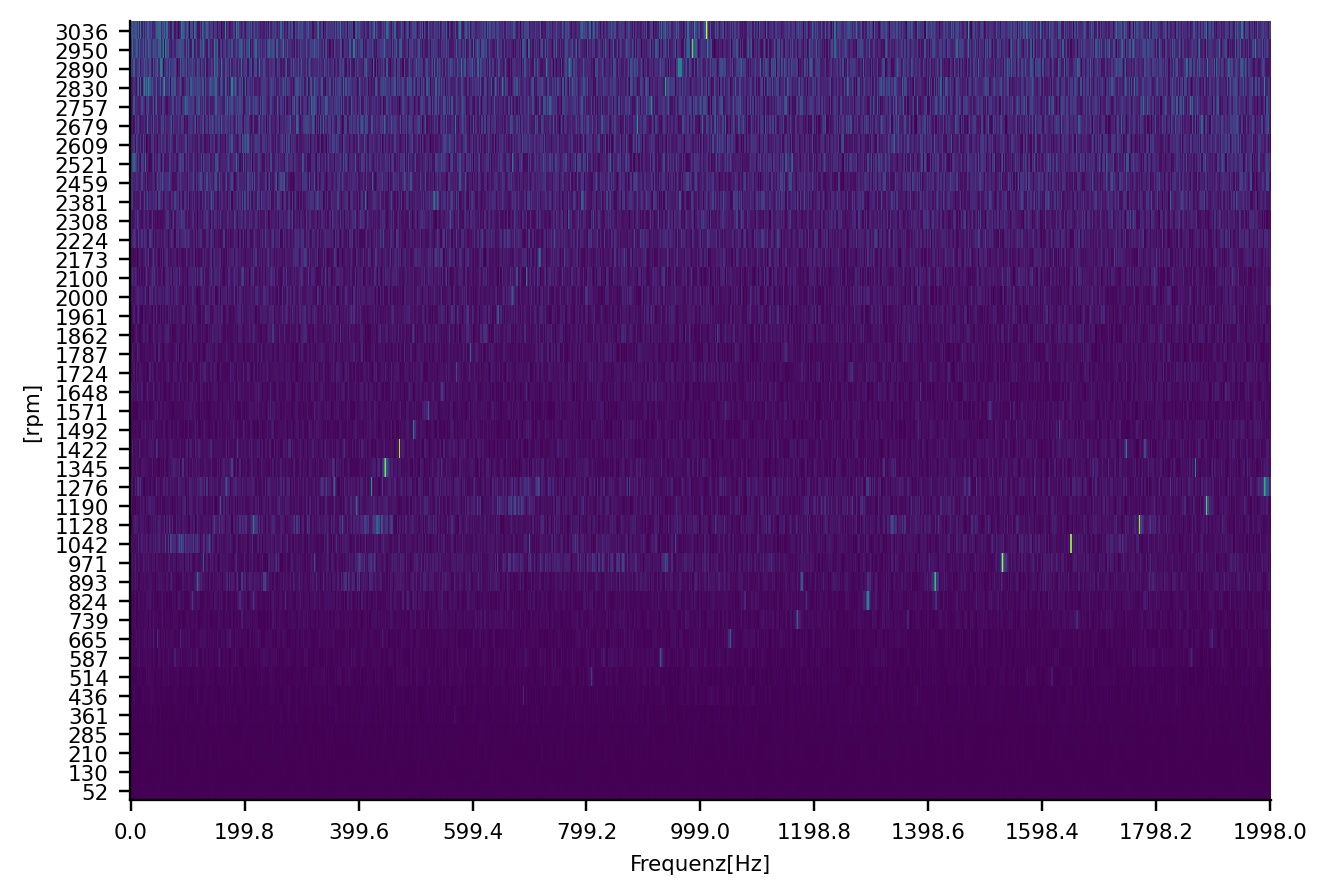

In [6]:
plt.rcParams.update({'font.size': 7})

plt.imshow(amp_fft_grid, interpolation='none', origin='lower', aspect='auto')

index = np.linspace(0, len(freq)-1, 11, True, dtype=int)
plt.xticks(index, np.round(freq[index], 2))
plt.yticks(np.arange(len(motor_rpm)), labels=motor_rpm)
plt.xlabel("Frequenz[Hz]")
plt.ylabel("[rpm]")

plt.show()

## Zweiter Datensatz: Prüfstand #3

#### 1. Einlesen der Mess- und Metadaten

In [7]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_112539_lavalrotor_01_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_112539_lavalrotor_01_03.h5"

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))
uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

a_x = []
a_y = []
a_z = []
motor_rpm = []
t = []

number_rpms = 0
with h5py.File(path_measurement_folder+"/"+filename, 'r') as f:
    number_rpms = len(f.keys())
    for key in range(number_rpms):

        a_x.append( f[str(key)]["RawData"][uuid_acceleration]["acceleration_x"][()])
        a_y.append( f[str(key)]["RawData"][uuid_acceleration]["acceleration_y"][()])
        a_z.append( f[str(key)]["RawData"][uuid_acceleration]["acceleration_z"][()])
        t.append( f[str(key)]["RawData"][uuid_acceleration]["timestamp"][()])
        motor_rpm.append( f[str(key)]["RawData"][uuid_motor_rpm]["motor_rpm"][()])
        
amp_fft_grid = np.zeros((number_rpms, int(number_interpolation_points/2)+1))

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [8]:
importlib.reload(m_postprocessing)  # reload functions
for i in range(number_rpms):
    a = m_postprocessing.get_vec_accel(a_x[i], a_y[i], a_z[i])
    int_a = m_postprocessing.interpolation(t[i], a, interpolation_points)
    amp_fft, freq = m_postprocessing.my_fft_scaled(int_a, interpolation_points)
    amp_fft_grid[i] = amp_fft

#### 3. Darstellung mittels Campbell-Diagramm

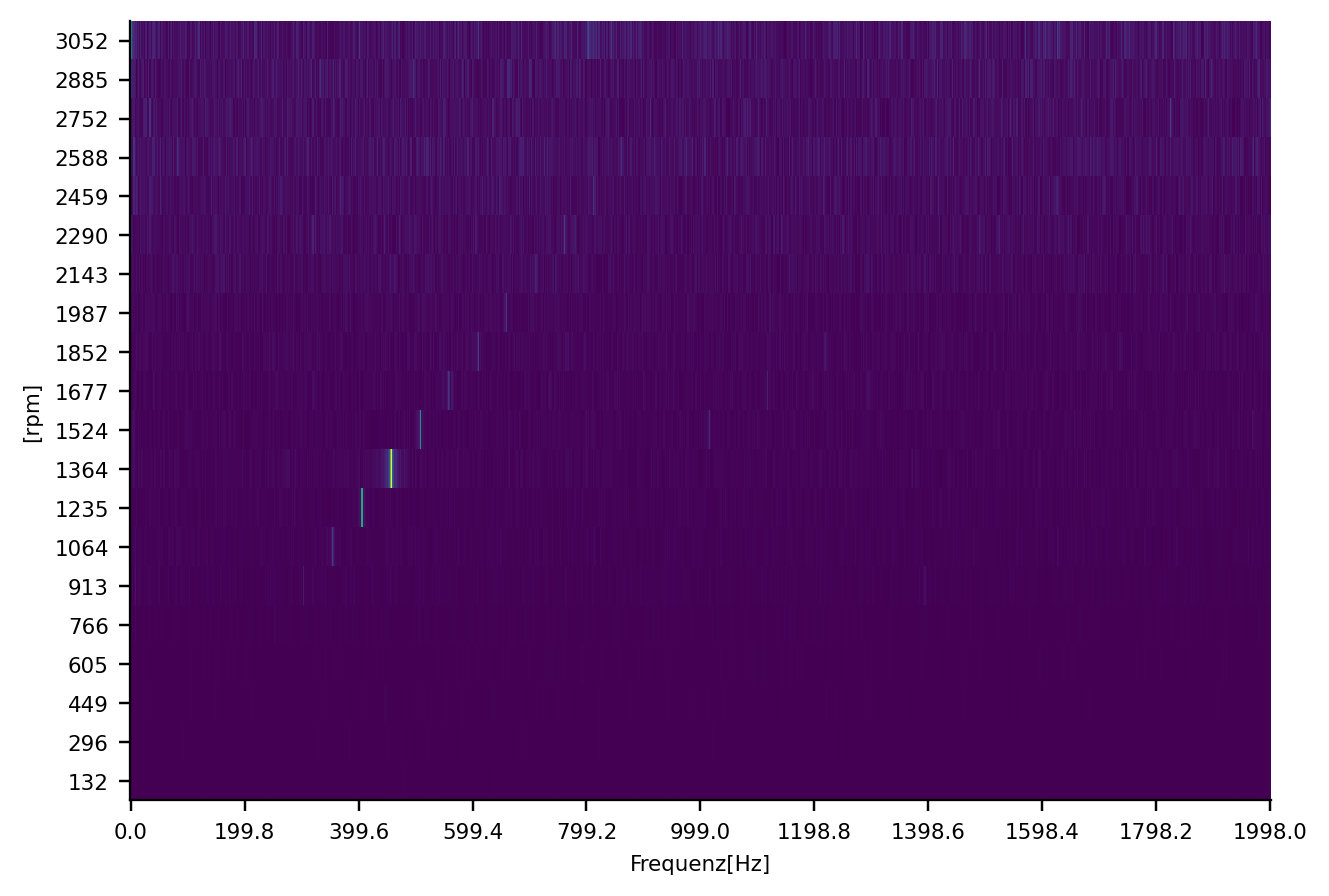

In [9]:
plt.rcParams.update({'font.size': 7})

plt.imshow(amp_fft_grid, interpolation='none', origin='lower', aspect='auto')

index = np.linspace(0, len(freq)-1, 11, True, dtype=int)
plt.xticks(index, np.round(freq[index], 2))
plt.yticks(np.arange(len(motor_rpm)), labels=motor_rpm)
plt.xlabel("Frequenz[Hz]")
plt.ylabel("[rpm]")

plt.show()

## Dritter Datensatz: Prüfstand #4

#### 1. Einlesen der Mess- und Metadaten

In [10]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_112539_lavalrotor_01_03"
)  # path to the folder with H5-file and metadata
filename =  "data_20240102_112539_lavalrotor_01_03.h5"

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

a_x = []
a_y = []
a_z = []
motor_rpm = []
t = []

number_rpms = 0
with h5py.File(path_measurement_folder+"/"+filename, 'r') as f:
    number_rpms = len(f.keys())
    for key in range(number_rpms):

        a_x.append( f[str(key)]["RawData"][uuid_acceleration]["acceleration_x"][()])
        a_y.append( f[str(key)]["RawData"][uuid_acceleration]["acceleration_y"][()])
        a_z.append( f[str(key)]["RawData"][uuid_acceleration]["acceleration_z"][()])
        t.append( f[str(key)]["RawData"][uuid_acceleration]["timestamp"][()])
        motor_rpm.append( f[str(key)]["RawData"][uuid_motor_rpm]["motor_rpm"][()])
        
amp_fft_grid = np.zeros((number_rpms, int(number_interpolation_points/2)+1))

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [11]:
importlib.reload(m_postprocessing)  # reload functions
for i in range(number_rpms):
    a = m_postprocessing.get_vec_accel(a_x[i], a_y[i], a_z[i])
    int_a = m_postprocessing.interpolation(t[i], a, interpolation_points)
    amp_fft, freq = m_postprocessing.my_fft_scaled(int_a, interpolation_points)
    amp_fft_grid[i] = amp_fft

#### 3. Darstellung mittels Campbell-Diagramm

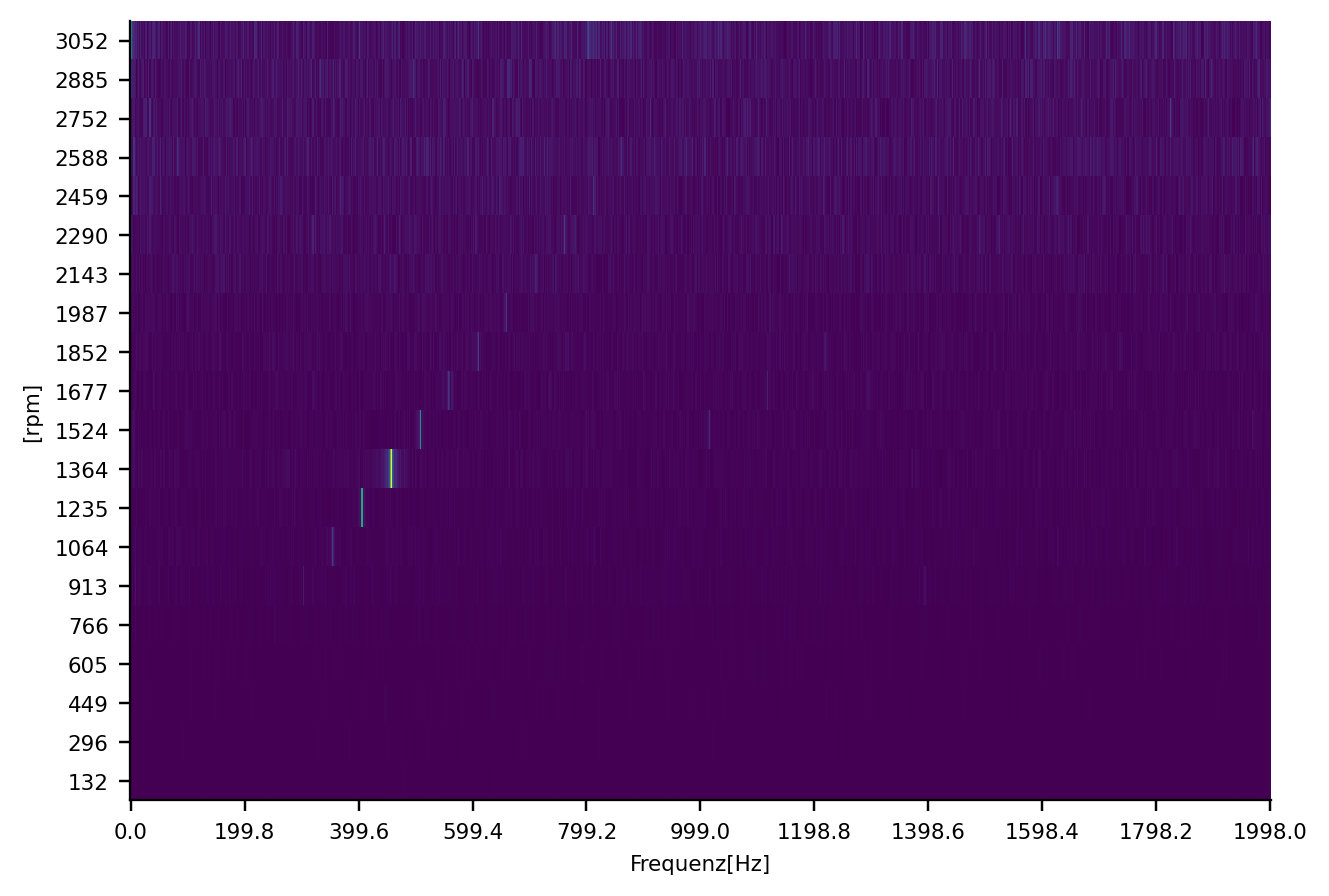

In [12]:
plt.rcParams.update({'font.size': 7})

plt.imshow(amp_fft_grid, interpolation='none', origin='lower', aspect='auto')

index = np.linspace(0, len(freq)-1, 11, True, dtype=int)
plt.xticks(index, np.round(freq[index], 2))
plt.yticks(np.arange(len(motor_rpm)), labels=motor_rpm)
plt.xlabel("Frequenz[Hz]")
plt.ylabel("[rpm]")

plt.show()

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Das Rauschen der Diagramme ist sehr groß. Es ist sehr schwer hier genaue Ergebnisse zu bestimmen. <br>
Prüfstand 2 hat 2 Scheiben mit je 500g 473rpm/1835rpm
Prüfstand 3 hat 1 Scheibe mit 950g  ~500rpm/600rpm
Prüfstand 4 hat 1 Scheibe mit 1000g ~600rpm/700rpm

Bei 2 Scheiben sind die kritische Drehzahlen höher als bei einer Scheibe. 
Der Unterschied zwischen den Gewichten von Prüfstand 3 & 4 sind sehr gering, aber es scheint so als wären die kritischen Drehzahlen von Prüfstand 3 geringer. 

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

$$
m = 0,5kg \\
l = 0,75m \\
E = 210000 \frac{N}{mm^2} \\
s = 250mm \\
d = 8mm \\
a = 250mm \\
\frac{F}{w} = \frac{6EI}{3alx-3a^2x-x^3} \\
x = a = \frac{l}{3} \\
\frac{3l^3}{9}-\frac{3l^3}{27}-\frac{l^3}{27} = l^3\frac{5}{27} \\
k = \frac{F}{w} = \frac{EI}{l^3}32,4 \\
I = \frac{\pi d^4}{64} \\
\alpha_1 = \frac{64}{81} \\
\alpha_2 = \frac{56}{81} \\
\omega_1 = \sqrt{\frac{k}{m(\alpha_1+\alpha_2)}} = 49,62 \frac{rad}{s} \approx 473,87 rpm\\
\omega_2 = \sqrt{\frac{k}{m(\alpha_1-\alpha_2)}} = 192,189 \frac{rad}{s} \approx 1835,27 rpm \\
$$
<img src="images/Campbell_Diagramm_eingezeichnet.png" width="500">
Abgelesen aus dem Diagramm:
$$
\omega_{D1} \approx 450 rpm \\
\omega_{D2} \approx 1850 rpm \\
$$

Die kritischen Drehzahlen sind ähnlich. Das Einzeichnen/Ablesen führt aber zu ungenauen Werten.
Allerdings kann es auch bei der Berechnung zu Fehlern kommen, da Materialkonstanten empirisch bestimmt wurden. 

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Es war sehr interessant die Schwingungen in Präsenz zu beobachten. Ich finde es etwas schade, dass die Diagramme recht schwer zu erkennen sind. 
Es war insgesamt eine recht interessante Veranstaltung und hilfreich um etwas anderes mitzubekommen als die klassische Vorlesung. 